In [0]:
import numpy as np                  # for working with tensors outside the network
import pandas as pd                 # for data reading and writing
import matplotlib.pyplot as plt     # for data inspection

In [0]:
from keras.layers import Input, Conv2D, Activation, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout , Flatten
from keras.layers.merge import add
from keras.activations import relu, softmax
from keras.models import Model
from keras import regularizers


Using TensorFlow backend.


In [0]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
import itertools

In [0]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
## multiclass or binary report
## If binary (sigmoid output), set binary parameter to True
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size=32,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict(x, batch_size=batch_size)
    
    
    
    if not binary:
        y_pred = np.argmax(y_pred,axis=1)
    print(y_true.shape , y_pred.shape)
    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix,classes=classes)

In [0]:
def block(n_output, upscale=False):
    # n_output: number of feature maps in the block
    # upscale: should we use the 1x1 conv2d mapping for shortcut or not
    
    # keras functional api: return the function of type
    # Tensor -> Tensor
    def f(x):
        
        # H_l(x):
        # first pre-activation
        h = BatchNormalization()(x)
        h = Activation(relu)(h)
        # first convolution
        h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same', kernel_regularizer=regularizers.l1(0.01))(h)
        
        # second pre-activation
        h = BatchNormalization()(x)
        h = Activation(relu)(h)
        # second convolution
        h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same', kernel_regularizer=regularizers.l1(0.01))(h)
        
        # f(x):
        if upscale:
            # 1x1 conv2d
            f = Conv2D(kernel_size=1, filters=n_output, strides=1, padding='same')(x)
        else:
            # identity
            f = x
        
        # F_l(x) = f(x) + H_l(x):
        return add([f, h])
    
    return f

In [0]:
# input tensor is the 28x28 grayscale image
input_tensor = Input((28, 28, 4))

# first conv2d with post-activation to transform the input data to some reasonable form
x = Conv2D(kernel_size=3, filters=16, strides=1, padding='same', kernel_regularizer=regularizers.l1(0.01))(input_tensor)
x = BatchNormalization()(x)
x = Activation(relu)(x)

# F_1
x = block(16)(x)
# F_2
x = block(16)(x)

# F_3
# H_3 is the function from the tensor of size 28x28x16 to the the tensor of size 28x28x32
# and we can't add together tensors of inconsistent sizes, so we use upscale=True
x = block(32, upscale=True)(x)       # !!! <------- Uncomment for local evaluation
# F_4
x = block(32)(x)                     # !!! <------- Uncomment for local evaluation
# F_5
x = block(32)(x)                     # !!! <------- Uncomment for local evaluation

# F_6
x = block(48, upscale=True)(x)       # !!! <------- Uncomment for local evaluation
# F_7
x = block(48)(x)                     # !!! <------- Uncomment for local evaluation

# last activation of the entire network's output
x = BatchNormalization()(x)
x = Activation(relu)(x)

# average pooling across the channels
# 28x28x48 -> 1x48
x = GlobalAveragePooling2D()(x)

# add Dense layer by ganseo.park 11-28 11:56
# x = Flatten()(x)
# x = Dense(units=512,kernel_regularizer=regularizers.l2(0.01))(x)
# x = BatchNormalization()(x)
# x = Activation(relu)(x)

# dropout for more robust learning
x = Dropout(0.2)(x)

# last softmax layer
x = Dense(units=4, kernel_regularizer=regularizers.l1(0.01))(x)
x = Activation(softmax)(x)

model = Model(inputs=input_tensor, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
X_train = pd.read_csv(tf.gfile.Open('/content/gdrive/My Drive/X_train.csv'),header=None)
Y_train = pd.read_csv(tf.gfile.Open('/content/gdrive/My Drive/y_train.csv'),header=None)
X_test = pd.read_csv(tf.gfile.Open('/content/gdrive/My Drive/X_test.csv'),header=None)
Y_test = pd.read_csv(tf.gfile.Open('/content/gdrive/My Drive/y_test_onehot.csv'),header=None)
# Y_test = pd.get_dummies(Y_test , columns=[0])

In [0]:
X_train_add_aug = pd.read_csv(tf.gfile.Open('/content/gdrive/My Drive/x_train_aug_list_except_original_2.csv'),header=None)
Y_train_add_aug = pd.read_csv(tf.gfile.Open('/content/gdrive/My Drive/y_train_aug_list_except_original_2.csv'),header=None)
X_add_labeled = pd.read_csv(tf.gfile.Open('/content/gdrive/My Drive/add_label.csv'),header=0)

In [0]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135
0,185,176,149,185,186,175,145,186,186,175,...,147,188,181,169,147,190,187,178,147,191
1,119,130,107,160,108,109,88,146,111,104,...,64,104,153,145,144,148,142,130,121,133
2,143,145,137,170,130,126,116,156,130,122,...,156,192,186,170,160,193,178,162,150,185
3,152,162,132,191,157,167,137,192,158,166,...,158,193,199,182,157,196,199,179,154,199
4,180,152,126,205,188,169,145,215,176,149,...,121,197,165,139,120,197,159,129,105,192


In [0]:
# X_train_add_aug= X_train_add_aug.drop([0] , axis=1)
# col = list(X_train.columns)
# X_train_add_aug.columns = col
# Y_train_add_aug= Y_train_add_aug.drop([0] , axis=1)
# col = list(Y_train.columns)
# Y_train_add_aug.columns = col

In [0]:
X_add_labeled= X_add_labeled.drop(['Unnamed: 0'] , axis=1)
X_add_labeled = X_add_labeled[X_add_labeled.prob>0.9]
X_add_labeled= X_add_labeled.drop(['prob'] , axis=1)
Y_add_labeled = X_add_labeled['label']
X_add_labeled= X_add_labeled.drop(['label'] , axis=1)
col = list(X_train.columns)
X_add_labeled.columns = col
Y_add_labeled = pd.get_dummies(Y_add_labeled , columns=[0])

In [0]:
X_train = X_train.as_matrix()
Y_train = Y_train.as_matrix()
X_test = X_test.as_matrix()
Y_test = Y_test.as_matrix()


In [0]:
X_add_labeled= X_add_labeled.as_matrix()
Y_add_labeled= Y_add_labeled.as_matrix()
X_train_add_aug= X_train_add_aug.as_matrix()
Y_train_add_aug= Y_train_add_aug.as_matrix()

In [0]:

x_val = X_train.reshape([-1,28,28,4]).astype(float)
x_train = X_add_labeled.reshape([-1,28,28,4]).astype(float)
x_test = X_test.reshape([-1,28,28,4]).astype(float)
x_train_add_aug= X_train_add_aug.reshape([-1,28,28,4]).astype(float)

y_val = Y_train
y_train = Y_add_labeled
y_test = Y_test
y_train_add_aug= Y_train_add_aug

In [0]:
x_train.shape , x_val.shape , x_test.shape , x_train_add_aug.shape , y_val.shape , y_train.shape ,  y_test.shape , y_train_add_aug.shape

((9596, 28, 28, 4),
 (2000, 28, 28, 4),
 (10000, 28, 28, 4),
 (15992, 28, 28, 4),
 (2000, 4),
 (9596, 4),
 (10000, 4),
 (15992, 4))

In [0]:
x_grid = np.append([x_train] , [x_train_add_aug])
x_grid = np.append([x_grid] , [x_val])
x_grid = x_grid.reshape(-1,28,28,4)
x_grid.shape

(27588, 28, 28, 4)

In [0]:
y_grid = np.append([y_train] , [y_train_add_aug])
y_grid = np.append([y_grid] , [y_val])
y_grid = y_grid.reshape(-1,4)
y_grid.shape

(27588, 4)

In [0]:
xtr , xval , ytr , yval = train_test_split(x_grid , y_grid , test_size=0.1 , random_state=42)

In [0]:
xtr.shape , xval.shape , ytr.shape , yval.shape

((24829, 28, 28, 4), (2759, 28, 28, 4), (24829, 4), (2759, 4))

In [0]:
m = x_grid.mean(axis=0)

xtr -= m
xval -= m

In [0]:
# m = x_grid.mean(axis=0)

# x_train -= m
# x_val -= m
# x_test -= m
# x_train_add_aug -= m
# x_grid -= m

In [0]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [0]:
mc = ModelCheckpoint('weights.best.keras', monitor='val_acc', save_best_only=True)

In [0]:
def sigmoidal_decay(e, start=0, end=100, lr_start=1e-3, lr_end=1e-5):
    if e < start:
        return lr_start
    
    if e > end:
        return lr_end
    
    middle = (start + end) / 2
    s = lambda x: 1 / (1 + np.exp(-x))
    
    return s(13 * (-e + middle) / np.abs(end - start)) * np.abs(lr_start - lr_end) + lr_end

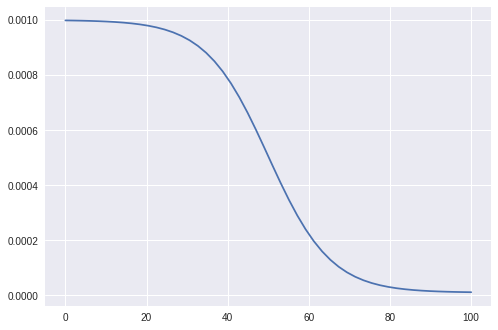

In [0]:
xs = np.linspace(0, 100)
ys = np.vectorize(sigmoidal_decay)(xs)
plt.plot(xs, ys)
plt.show()

In [0]:
EPOCHS = 100                        # !!! <------- Chnage to 30-100 for local evaluation

In [0]:
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=EPOCHS))

In [0]:
hist = model.fit(xtr, ytr, epochs=EPOCHS, validation_data=(xval, yval), batch_size=512, callbacks=[lr, mc])

Train on 24829 samples, validate on 2759 samples
Epoch 1/100
24829/24829 [==============================] - 13s 505us/step - loss: 9.4739 - acc: 0.8391 - val_loss: 4.1161 - val_acc: 0.7506
Epoch 2/100
24829/24829 [==============================] - 12s 466us/step - loss: 2.2429 - acc: 0.8921 - val_loss: 1.8355 - val_acc: 0.7956
Epoch 3/100
24829/24829 [==============================] - 12s 467us/step - loss: 1.1920 - acc: 0.9119 - val_loss: 1.4657 - val_acc: 0.7419
Epoch 4/100
24829/24829 [==============================] - 12s 465us/step - loss: 0.9377 - acc: 0.9236 - val_loss: 1.3619 - val_acc: 0.6713
Epoch 5/100
24829/24829 [==============================] - 12s 466us/step - loss: 0.8441 - acc: 0.9242 - val_loss: 1.3341 - val_acc: 0.5890
Epoch 6/100
24829/24829 [==============================] - 12s 468us/step - loss: 0.7637 - acc: 0.9294 - val_loss: 1.2910 - val_acc: 0.6941
Epoch 7/100
24829/24829 [==============================] - 12s 466us/step - loss: 0.7083 - acc: 0.9321 - val_lo

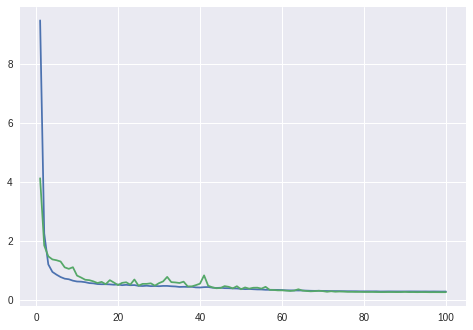

In [0]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = np.arange(1, EPOCHS + 1)

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.show()

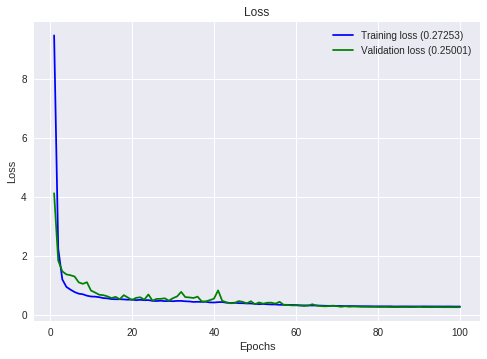

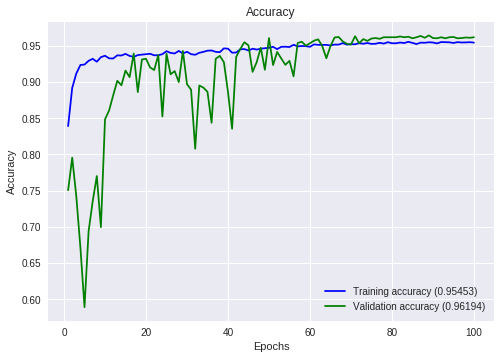

In [0]:
plot_history(hist)

In [0]:
X_test = pd.read_csv(tf.gfile.Open('/content/gdrive/My Drive/X_test_new.csv'),header=None)
Y_test = pd.read_csv(tf.gfile.Open('/content/gdrive/My Drive/y_test_new.csv'),header=None)
X_test = X_test.as_matrix()
Y_test = Y_test.as_matrix()
x_test = X_test.reshape([-1,28,28,4]).astype(float)
y_test = Y_test
x_test -= m

In [0]:
ratios = np.sum(y_val , axis=0)/y_val.shape[0]
labels = ['Barren Land' ,'Trees' , 'Grassland' , 'other']

for l,v in zip(labels , ratios*100):
    print("{}:{:.1f}%".format(l,v))

Barren Land:12.5%
Trees:12.5%
Grassland:25.0%
other:50.0%


In [0]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model_11281555.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model_11281555.h5")
print("Saved model to disk")

Saved model to disk


(10000,) (10000,)
Accuracy : 0.9526

Classification Report
             precision    recall  f1-score   support

          0    0.98412   0.94200   0.96260      2500
          1    0.99520   0.91240   0.95200      2500
          2    0.93045   0.96320   0.94654      2500
          3    0.91016   0.99280   0.94968      2500

avg / total    0.95498   0.95260   0.95271     10000

[[2355    0   92   53]
 [   0 2281   79  140]
 [  31    9 2408   52]
 [   7    2    9 2482]]


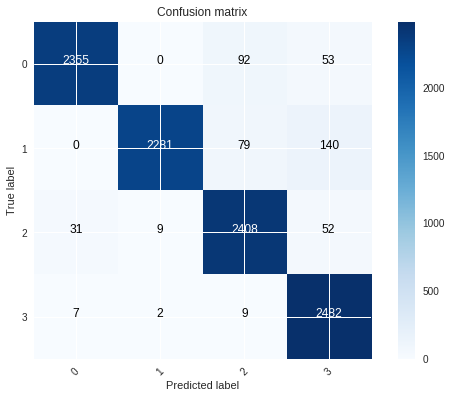

In [0]:
model.load_weights('weights.best.keras')
labels = {0:'Barren Land' ,1:'Trees' , 2:'Grassland' , 3:'other'}
full_multiclass_report(model,
                       x_test,
                       y_test,labels )

In [0]:
p_test = model.predict(x_val, batch_size=512)
p_test = np.argmax(p_test, axis=1)

In [0]:
pd.DataFrame({'ImageId': 1 + np.arange(p_test.shape[0]), 'Label': p_test}).to_csv('output.csv', index=False)

In [0]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [0]:
# load YAML and create model
yaml_file = open('model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [0]:
def create_model(dense_layers=[8],
                 activation='relu',
                 optimizer='rmsprop'):
    # input tensor is the 28x28 grayscale image
    input_tensor = Input((28, 28, 4))

    # first conv2d with post-activation to transform the input data to some reasonable form
    x = Conv2D(kernel_size=3, filters=16, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(relu)(x)

    # F_1
    x = block(16)(x)
    # F_2
    x = block(16)(x)

    # F_3
    # H_3 is the function from the tensor of size 28x28x16 to the the tensor of size 28x28x32
    # and we can't add together tensors of inconsistent sizes, so we use upscale=True
    x = block(32, upscale=True)(x)       # !!! <------- Uncomment for local evaluation
    # F_4
    x = block(32)(x)                     # !!! <------- Uncomment for local evaluation
    # F_5
    x = block(32)(x)                     # !!! <------- Uncomment for local evaluation

    # F_6
    x = block(48, upscale=True)(x)       # !!! <------- Uncomment for local evaluation
    # F_7
    x = block(48)(x)                     # !!! <------- Uncomment for local evaluation

    # last activation of the entire network's output
    x = BatchNormalization()(x)
    x = Activation(relu)(x)

    # average pooling across the channels
    # 28x28x48 -> 1x48
    x = GlobalAveragePooling2D()(x)

    # add Dense layer by ganseo.park 11-28 11:56
    # x = Flatten()(x)
    for index, lsize in enumerate(dense_layers):
      if index == 0:
        x = Dense(units=lsize,kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Activation(activation)(x)    
      else:
        x = Dense(units=lsize,kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Activation(activation)(x)  
#     x = Dense(units=128,kernel_regularizer=regularizers.l2(0.01))(x)
#     x = BatchNormalization()(x)
#     x = Activation(relu)(x)

    # dropout for more robust learning
    x = Dropout(0.5)(x)

    # last softmax layer
    x = Dense(units=4, kernel_regularizer=regularizers.l2(0.01))(x)
    x = Activation(softmax)(x)

    model = Model(inputs=input_tensor, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=create_model,
                        epochs=10, 
                        batch_size=32,
                        verbose=1)

In [0]:
param_grid = {
    'dense_layers': [[128],[256]],
              'activation':['relu','tanh'],
              'optimizer':('rmsprop','adam'),
              'epochs':[50,100],
              'batch_size':[256,512,768]}

In [0]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
grid = GridSearchCV(model,
                    param_grid=param_grid,
                    cv=5,
                    return_train_score=True,
#                    scoring=['precision_macro','recall_macro','f1_macro'],
                    refit='precision_macro')

In [0]:
x_grid = np.append(x_train , x_val).reshape(-1,28,28,4)
y_grid = np.append(y_train , y_val).reshape(-1,4)

In [0]:

grid_results = grid.fit(x_grid,y_grid)
print('Parameters of the best model: ')
print(grid_results.best_params_)

Epoch 1/50
9276/9276 [==============================] - 8s 877us/step - loss: 2.9940 - acc: 0.8427
Epoch 2/50
9276/9276 [==============================] - 5s 502us/step - loss: 2.0685 - acc: 0.9224
Epoch 3/50
9276/9276 [==============================] - 5s 502us/step - loss: 1.5214 - acc: 0.9274
Epoch 4/50
9276/9276 [==============================] - 5s 501us/step - loss: 1.1418 - acc: 0.9305
Epoch 5/50
9276/9276 [==============================] - 5s 499us/step - loss: 0.8912 - acc: 0.9356
Epoch 6/50
9276/9276 [==============================] - 5s 501us/step - loss: 0.7278 - acc: 0.9350
Epoch 7/50
9276/9276 [==============================] - 5s 501us/step - loss: 0.6085 - acc: 0.9393
Epoch 8/50
9276/9276 [==============================] - 5s 499us/step - loss: 0.5396 - acc: 0.9354
Epoch 9/50
9276/9276 [==============================] - 5s 499us/step - loss: 0.4801 - acc: 0.9388
Epoch 10/50
9276/9276 [==============================] - 5s 500us/step - loss: 0.4245 - acc: 0.9451
Epoch 11/

In [0]:
## Capture the best params
params = grid_results.best_params_

## create the model with the best params found
model = create_model(dense_layers=params['dense_layers'],
                     activation=params['activation'],
                     optimizer=params['optimizer'])

## Then train it and display the results
history = model.fit(x_train,
                    y_train,
                    epochs=params['epochs'],
                    batch_size=params['batch_size'],
                    verbose = 0)

model.summary()
plot_history(history)
full_multiclass_report(model,
                       x_test,
                       y_test,
                       classes=labels)

In [0]:
model.save_weights('weightsfile.h5')
model.save_model('model.hdf5')